# Importing library


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import pydot
import graphviz

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [3]:
# create a list of our conditions
conditions = [
    (df_train['label'] == 0),
    (df_train['label'] == 1)
    ]

# create a list of the values we want to assign for each condition
values = ['positive', 'negative']

# create a new column and use np.select to assign values to it using our lists as arguments
df_train['sentiment'] = np.select(conditions, values)

# display updated DataFrame
df_train

,id,label,tweet,sentiment
0,1,0,@user when a father is dysfunctional and is s...,positive
1,2,0,@user @user thanks for #lyft credit i can't us...,positive
2,3,0,bihday your majesty,positive
3,4,0,#model i love u take with u all the time in ...,positive
4,5,0,factsguide: society now #motivation,positive
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,positive
31958,31959,0,to see nina turner on the airwaves trying to...,positive
31959,31960,0,listening to sad songs on a monday morning otw...,positive
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",negative


# Examining the dataset 

In [4]:
#Checking for null values
df_train['tweet'].isnull().sum()

0

In [5]:
#checking count of labels
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

C:\Users\masen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

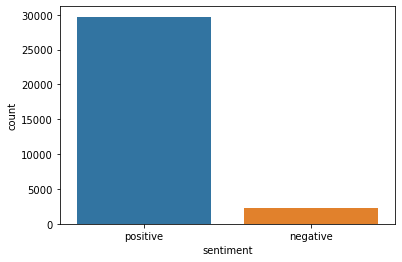

In [6]:
sns.countplot(df_train['sentiment'])

C:\Users\masen\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tweet', ylabel='Density'>

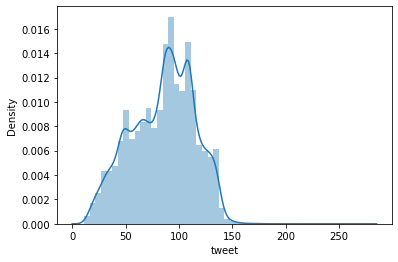

In [7]:
# finding length of tweets
lens = df_train['tweet'].str.len()
sns.distplot(lens)

In [8]:
np.median(df_train['tweet'].str.len())

88.0

<AxesSubplot:>

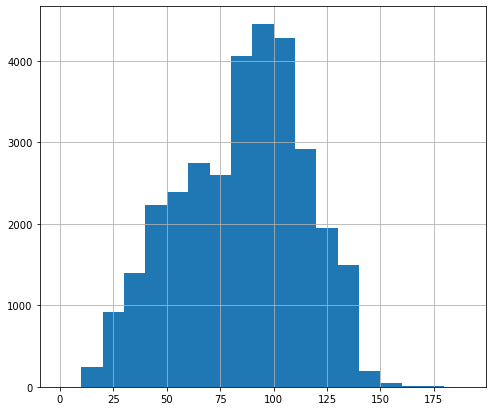

In [9]:
plt.figure(figsize=(8,7))
lens.hist(bins = np.arange(0,200,10))

# Data Preprocessing

In [10]:
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)
df_test

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."
...,...
17192,thought factory: left-right polarisation! #tru...
17193,feeling like a mermaid ð #hairflip #neverre...
17194,#hillary #campaigned today in #ohio((omg)) &am...
17195,"happy, at work conference: right mindset leads..."


In [11]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
df_train['tweet'] = df_train['tweet'].map(lambda t: clean_text(t))
df_test['tweet'] = df_test['tweet'].map(lambda t: clean_text(t))

In [13]:
df_train['tweet']

0        user when a father is dysfunctional and is so ...
1        user user thanks for lyft credit i can not use...
2                                      bihday your majesty
3            model i love u take with u all the time in ur
4                        factsguide society now motivation
                               ...                        
31957                              ate user isz that youuu
31958    to see nina turner on the airwaves trying to w...
31959    listening to sad songs on a monday morning otw...
31960    user sikh temple vandalised in in calgary wso ...
31961                        thank you user for you follow
Name: tweet, Length: 31962, dtype: object

In [14]:
df_train['tweet'][0]

'user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run'

In [15]:
#removal of frequent words
def freq_removal(df):
    freq = pd.Series(' '.join(df_train['tweet']).split()).value_counts()[:10]
    freq = list(freq.index)
    
    df_train['tweet'] = df_train['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq)) 
    return freq

In [16]:
freq_removal(df_train)

['user', 'the', 'to', 'i', 'a', 'you', 'and', 'in', 'for', 'is']

In [17]:
df_train['tweet'][0]

'when father dysfunctional so selfish he drags his kids into his dysfunction run'

In [18]:
#removal of rare words
def rare_removal(df):
    rare = pd.Series(' '.join(df['tweet']).split()).value_counts()[-10:] 
    # we combine all the rows with " " .join() function and then split it and convert it into series
    # then find the value count
    rare = list(rare.index)
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

In [19]:
rare_removal(df_train)
print(df_train['tweet'])

0        when father dysfunctional so selfish he drags ...
1        thanks lyft credit can not use cause they do n...
2                                      bihday your majesty
3                     model love u take with u all time ur
4                        factsguide society now motivation
                               ...                        
31957                                   ate isz that youuu
31958    see nina turner on airwaves trying wrap hersel...
31959    listening sad songs on monday morning otw work...
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Name: tweet, Length: 31962, dtype: object


In [20]:
print(df_train['tweet'][1])

thanks lyft credit can not use cause they do not offer wheelchair vans pdx disapointed getthanked


In [21]:
#stemming and removing stop-words
stemmer=PorterStemmer()
def stem_remove_sw(df,text_col):
    corpus = []
    for i in range(len(df)):
        review = str(df[text_col][i])
        review = review.split()
        review = [stemmer.stem(word) for word in review if word not in stop_words]
        review = " ".join(review)
        corpus.append(review)
    return corpus

In [22]:
train_corpus = stem_remove_sw(df_train, 'tweet')
train_corpus[1]

'thank lyft credit use caus offer wheelchair van pdx disapoint getthank'

In [23]:
train_corpus

['father dysfunct selfish drag kid dysfunct run',
 'thank lyft credit use caus offer wheelchair van pdx disapoint getthank',
 'bihday majesti',
 'model love u take u time ur',
 'factsguid societi motiv',
 '2 2 huge fan fare big talk leav chao pay disput get allshowandnogo',
 'camp tomorrow danni',
 'next school year year exam think school exam hate imagin actorslif revolutionschool girl',
 'love land allin cav champion cleveland clevelandcavali',
 'welcom gr8',
 'ireland consum price index mom climb previou 0 2 0 5 may blog silver gold forex',
 'selfish orlando standwithorlando pulseshoot orlandoshoot biggerproblem selfish heabreak valu love',
 'get see daddi today 80day gettingf',
 'cnn call michigan middl school build wall chant tcot',
 'comment australia opkillingbay seashepherd helpcovedolphin thecov helpcovedolphin',
 'ouch junior angri got7 junior yugyoem omg',
 'thank paner thank posit',
 'retweet agre',
 'friday smile around via ig cooki make peopl',
 'know essenti oil made che

# Creating a bidirectional LSTM model & One Hot representation

In [24]:
tweets = df_train.tweet.values
tweets

array(['when father dysfunctional so selfish he drags his kids into his dysfunction run',
       'thanks lyft credit can not use cause they do not offer wheelchair vans pdx disapointed getthanked',
       'bihday your majesty', ...,
       'listening sad songs on monday morning otw work sad',
       'sikh temple vandalised calgary wso condemns act', 'thank follow'],
      dtype=object)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import one_hot

In [26]:
# One Hot representation
print(len(set(" ".join(train_corpus).split())))

32852


In [27]:
voc_size = 30000

In [28]:
onehot_repr=[one_hot(words,voc_size)for words in train_corpus] 
onehot_repr[0]

[27119, 26568, 9544, 22154, 5160, 26568, 10274]

In [29]:
sent_length=70
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ...  5160 26568 10274]
 [    0     0     0 ... 13018  9705 14097]
 [    0     0     0 ...     0 25720  3807]
 ...
 [    0     0     0 ...   466  2739  3641]
 [    0     0     0 ...  1848  7811 26171]
 [    0     0     0 ...     0 12679 21554]]


In [30]:
## Creating a bidirectional LSTM model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 40)            1200000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1,313,001
Trainable params: 1,313,001
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
X_lstm=np.array(embedded_docs)
Y_lstm = df_train["label"]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_lstm, Y_lstm, test_size=0.33, random_state=42)

In [33]:
model1.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
335/335 [==============================] - 48s 130ms/step - loss: 0.1878 - accuracy: 0.9420 - val_loss: 0.1423 - val_accuracy: 0.9489
Epoch 2/10
335/335 [==============================] - 37s 110ms/step - loss: 0.0787 - accuracy: 0.9731 - val_loss: 0.1304 - val_accuracy: 0.9592
Epoch 3/10
335/335 [==============================] - 36s 108ms/step - loss: 0.0436 - accuracy: 0.9853 - val_loss: 0.1554 - val_accuracy: 0.9516
Epoch 4/10
335/335 [==============================] - 35s 105ms/step - loss: 0.0261 - accuracy: 0.9924 - val_loss: 0.1800 - val_accuracy: 0.9594
Epoch 5/10
335/335 [==============================] - 35s 104ms/step - loss: 0.0171 - accuracy: 0.9953 - val_loss: 0.2003 - val_accuracy: 0.9558
Epoch 6/10
335/335 [==============================] - 35s 106ms/step - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.2309 - val_accuracy: 0.9555
Epoch 7/10
335/335 [==============================] - 36s 108ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.2501 - val_ac

In [34]:
y_pred_lstm=model1.predict(x_test)
y_pred_lstm = np.round(abs(y_pred_lstm))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_lstm))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred_lstm))
print(classification_report(y_test,y_pred_lstm))

Accuracy Score:  0.9494690936670459
Confusion Matrix: 
 [[9563  243]
 [ 290  452]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9806
           1       0.65      0.61      0.63       742

    accuracy                           0.95     10548
   macro avg       0.81      0.79      0.80     10548
weighted avg       0.95      0.95      0.95     10548



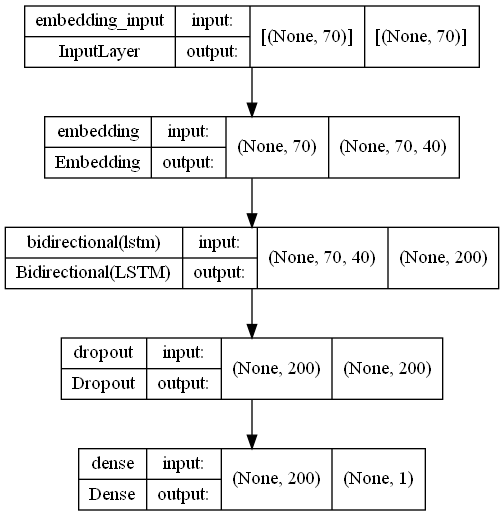

In [43]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model1, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# Visualizing all words in twitter

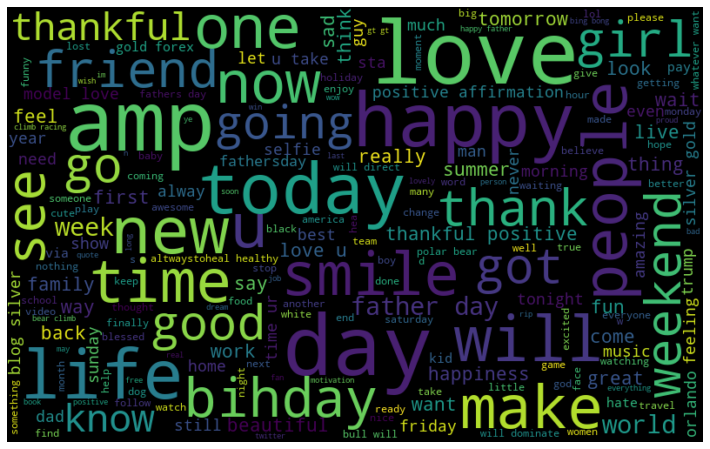

In [35]:
# Visualizing all words

all_words = " ".join(sent for sent in df_train['tweet'])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

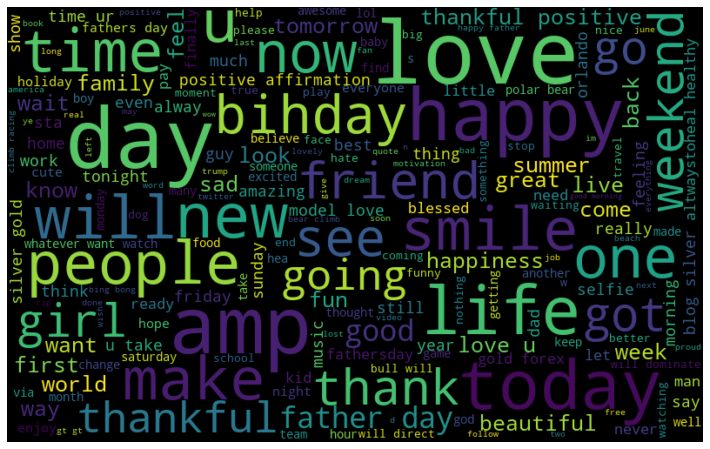

In [36]:
# Frequency of Positive Words

pos_words = " ".join(sent for sent in df_train['tweet'][df_train['label'] == 0])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(pos_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


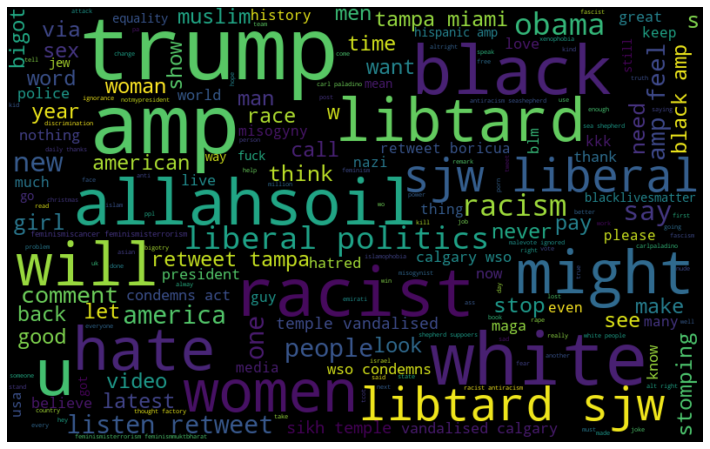

In [37]:
# Frequency of Negative Words

neg_words = " ".join(sent for sent in df_train['tweet'][df_train['label'] == 1])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(neg_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()